In [26]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
import cv2
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l, semantic_sam_t
from segment_anything import build_sam
from tree_segmentation import  TreePredictor, TreeSegmentMetric, Tree2D, MaskData
from tree_segmentation.util import show_masks, show_all_levels, image_add_mask_boundary
import pycocotools.mask as mask_util

/home/wan/Projects/Segmentation/TreeSeg


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
utils.set_printoptions(linewidth=120)

2.0.1+cu117


In [3]:
data_root = Path('/data5/SA-1B/')
data_part_1 = data_root.joinpath(f"{0:06d}")
images_paths = list(data_part_1.glob('*.jpg'))
print(f"There are {len(images_paths)} images")
print(len(list(data_part_1.glob('*.json'))))

There are 11186 images
11186


In [4]:
def read_annotations(json_path: Path):
    masks = []
    scores = []
    with open(json_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']
    for ann in annotations:
        scores.append(ann['predicted_iou'])
        masks.append(mask_util.decode(ann['segmentation']))
    scores = np.stack(scores)
    masks = np.stack(masks)
    tree2d = Tree2D(MaskData(masks=torch.from_numpy(masks), iou_preds=torch.from_numpy(scores)))
    tree2d.update_tree()
    return tree2d


# Debug

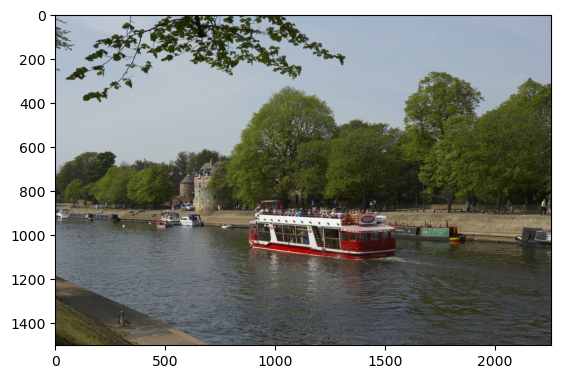

In [14]:
index = 8
image = utils.load_image(images_paths[index])
plt.imshow(image)

6

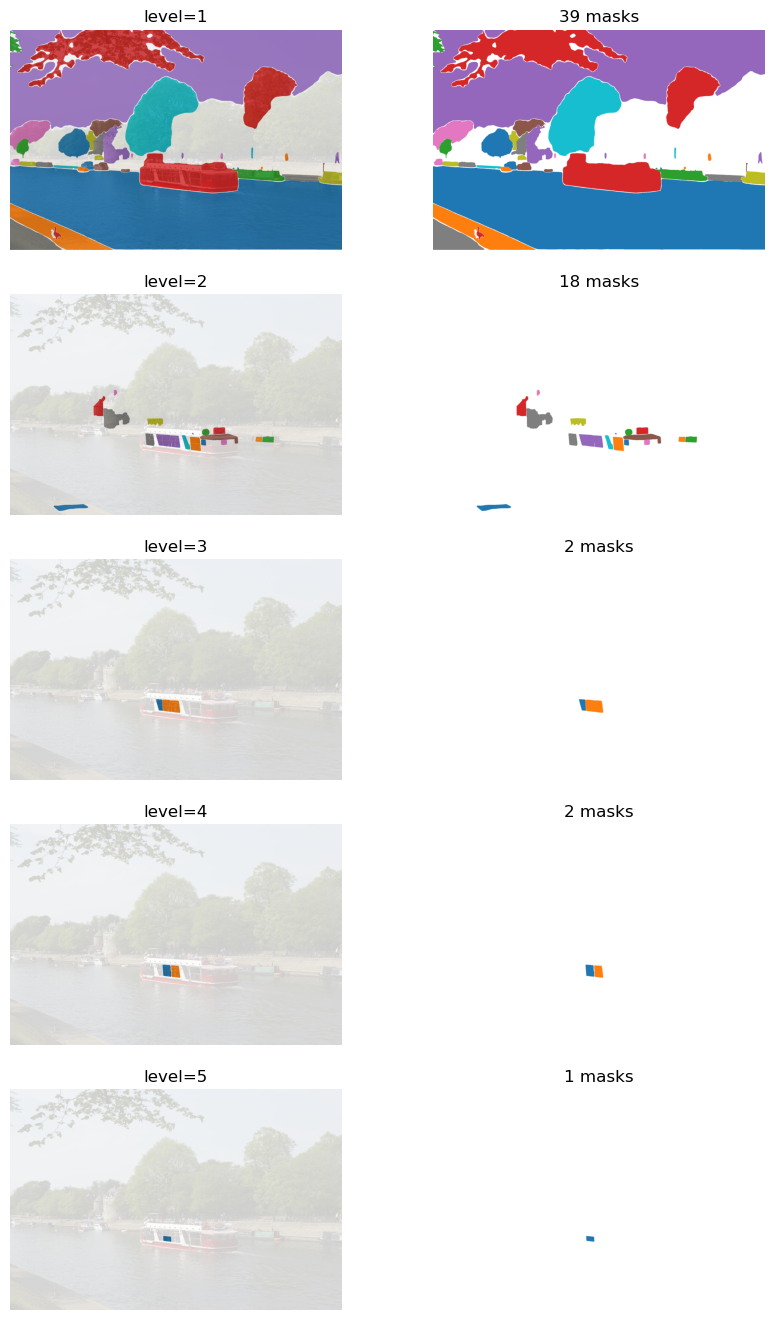

In [15]:
tree2d = read_annotations(images_paths[index].with_suffix('.json'))
# tree2d.print_tree()
show_all_levels(image, tree2d, alpha=0.8)

In [16]:
# load SAM
assert torch.cuda.is_available()
# model = build_sam(Path('./weights/sam_vit_h_4b8939.pth').expanduser())
model = semantic_sam_l(Path("./weights/swinl_only_sam_many2many.pth").expanduser())
# model = semantic_sam_t( Path("./weights/swint_only_sam_many2many.pth").expanduser())
model = model.eval().to(device)
tree_seg = TreePredictor(model, box_nms_thresh=0.9)

(1500, 2255, 3)
(681, 1024, 3)
[Tree] reset
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 98 to 75
[Tree2D] complete init segmentation
[Tree] Resize tree from 75 to 76
[Tree] Resize tree from 76 to 77
[Tree] Resize tree from 77 to 78
[Tree2D] Try to insert 51 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 78 to 78
[Tree2D] complete step 0 update segmentation
[Tree] Resize tree from 78 to 79
[Tree] Resize tree from 79 to 80
[Tree] Resize tree from 80 to 81
[Tree] Resize tree from 81 to 82
[Tree2D] Try to insert 55 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 82 to 82
[Tree2D] complete step 1 update segmentation
[Tree] Resize tree from 82 to 83
[Tree2D] Try to insert 53 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 83 to 83
[Tree2D] complete step 2 update segmentation
[Tree] Resize tree from 83 to 84
[Tree] Resize tree 

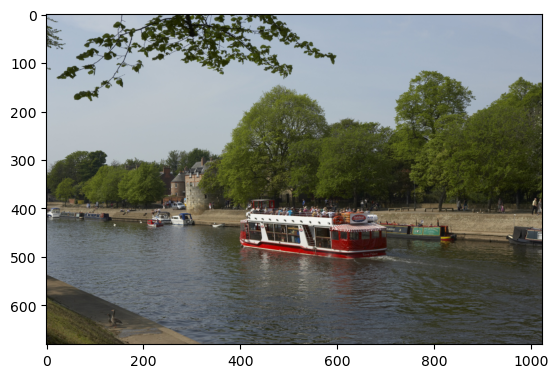

In [17]:
print(image.shape)
H, W, _ = image.shape
scale = min(1024 / H, 1024 / W)
image_resized = cv2.resize(image, (int(scale * W), int(scale * H)), interpolation=cv2.INTER_AREA)
print(image_resized.shape)
plt.imshow(image_resized)
timer = utils.TimeWatcher()
prediction = tree_seg.tree_generate(image_resized, device=device, timer=timer, verbose=1, max_steps=100)
print(timer)
print(timer.sum())

102


6

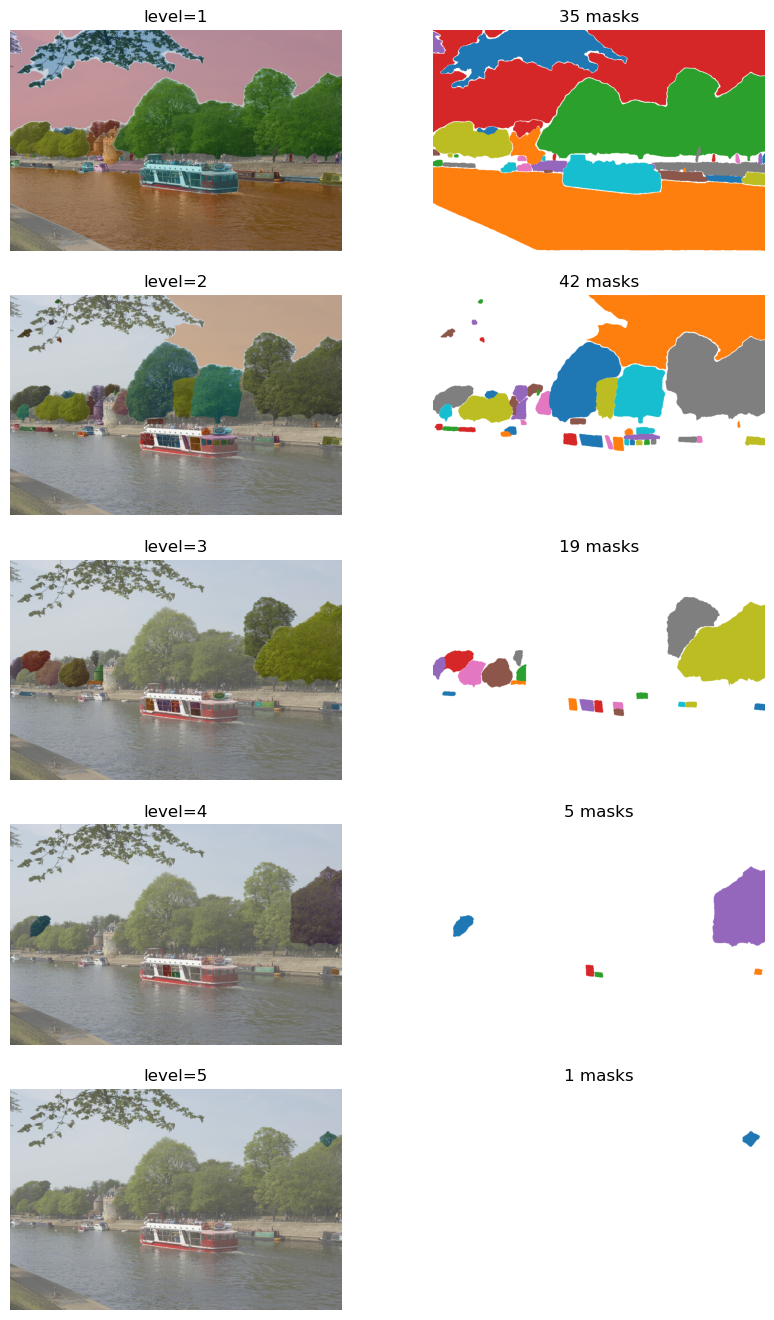

In [19]:
# prediction.print_tree()
print(prediction.num_masks)
show_all_levels(image_resized, prediction)

In [18]:
from tree_segmentation.metric import TreeSegmentMetric
metric = TreeSegmentMetric(is_resize_2d_as_gt=True)
metric.update(prediction.to(device), tree2d.to(device))
for k, v in metric.summarize().items():
    print(k, v)

[Tree2D] uncompress masks
SQ 0.8930440503497457
RQ 0.524390243902439
SS 0.7624742984771729
TQ 0.3570694492607844
PQ 0.4683035873785252
mIoU 0.6594497561454773
mR 0.5838709677419354
num 102.0
num_gt 62.0


In [29]:
indices = torch.cat(prediction.get_levels(), dim=0)[1:] - 1
scores = torch.zeros(len(indices), device=device)
for j, i in enumerate(indices):
    mask = prediction.masks[i]
    parent =  prediction.parent[i + 1].item()
    conflict = torch.zeros_like(mask)   if parent == 0  else  torch.logical_not(prediction.masks[parent-1])
    for c in prediction.get_children(parent):
        if c != i+1:
            conflict = torch.logical_or(conflict,  prediction.masks[c - 1])
    conflict = torch.logical_and(conflict, mask)
    scores[j] = conflict.sum() / mask.sum().clamp_min(1e-7)
print(indices)
print(scores)
print(1-scores.mean())

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
         22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101], device='cuda:0', dtype=torch.int32)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0111, 0.1127, 0.0417, 0.0367, 0.0244, 0.0389, 0.0039,
        0.0100, 0.0093, 0.0909, 0.0190, 0.0468, 0.151

now: tensor(47, device='cuda:0', dtype=torch.int32) score: tensor(0.1513, device='cuda:0')
p: tensor(22, device='cuda:0', dtype=torch.int32)


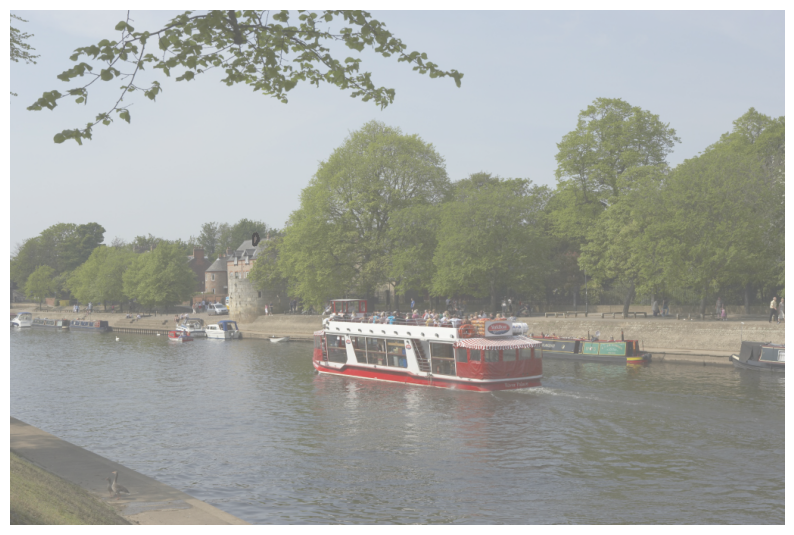

In [30]:
now = indices[scores.argmax()]
print('now:', now, 'score:', scores[indices.tolist().index(now)])
p = prediction.parent[now+1]
print('p:', p)
plt.figure(figsize=(10, 10))
img = image_add_mask_boundary(image_resized, prediction.masks[now])
# show_masks(img, *[prediction.masks[x-1] for x in prediction.get_children(p)])
mask_c = torch.zeros_like(prediction.masks[now])
for c in prediction.get_children(p):
    c = c -1
    if c != now:
        mask_c = mask_c | prediction.masks[c]
mask_c = mask_c & prediction.masks[now]
show_masks(img, mask_c)

generated
[Tree] reset
[Tree2D] 53 union with [(5, 0.5023499131202698)]
[Tree2D] 100 union with [(52, 0.38509318232536316)]
[Tree2D] 188 union with [(69, 0.4716311991214752)]
[Tree2D] 204 union with [(196, 0.2864019274711609)]
SQ 0.5619371348413927
RQ 0.7864406779661017
PQ 0.4419302212989936
TS 0.9961636066436768
TQ 0.44023481011390686
mSQ 0.9043310284614563
mRQ 0.43564680218696594
mPQ 0.3905128836631775
mTS 0.9976835250854492
mTQ 0.3895126283168793
mIoU 0.49354061484336853


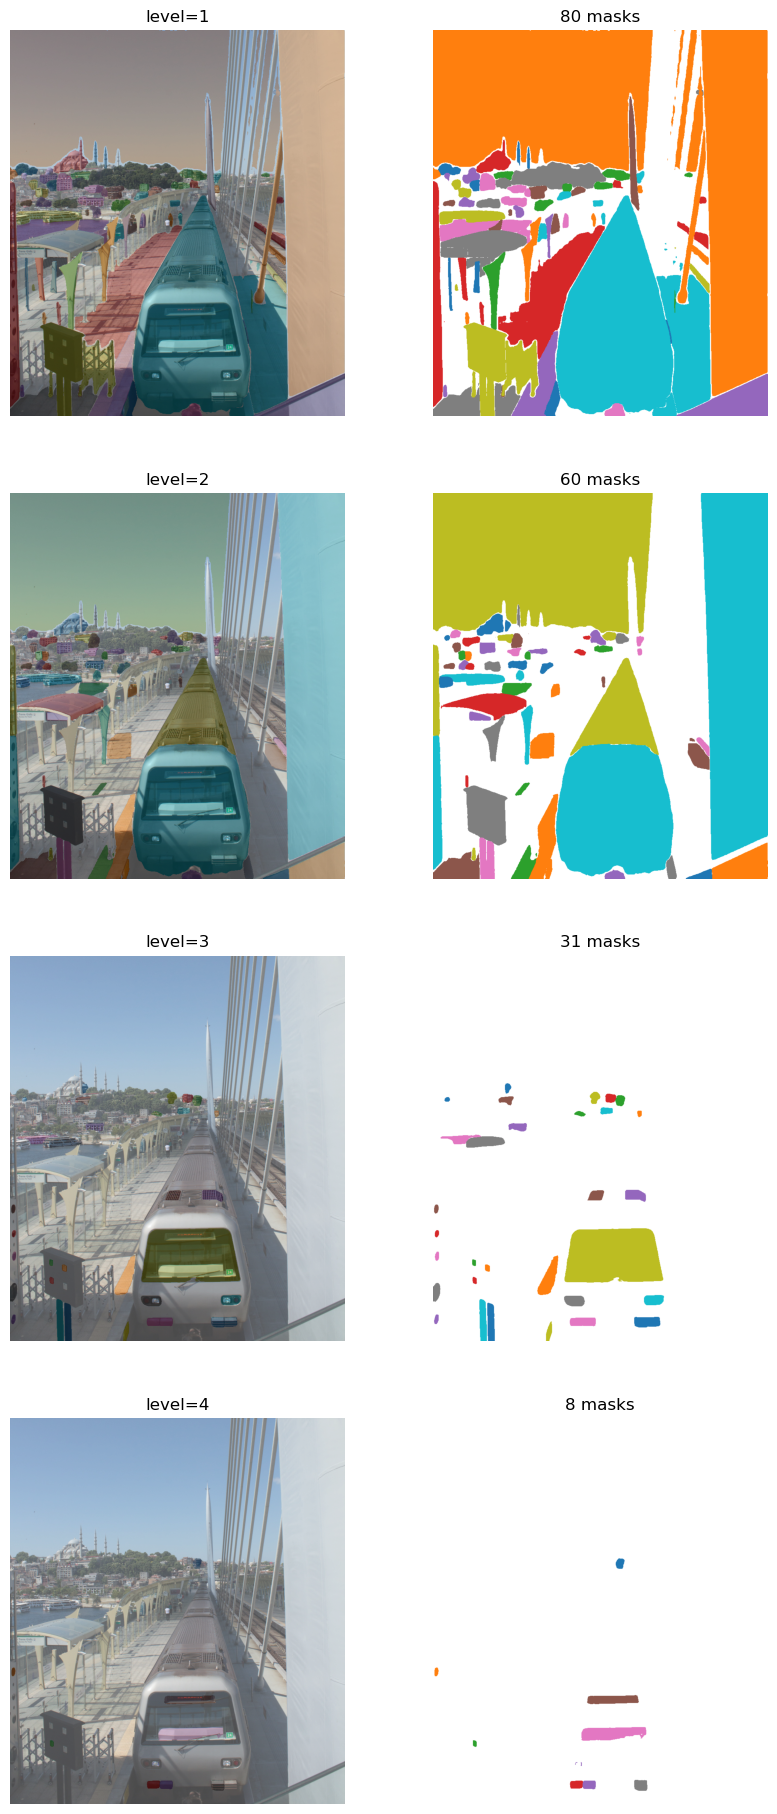

In [39]:
autogen = tree_seg.generate(image_resized)
print('generated')
tree_auto = Tree2D(
    masks=torch.from_numpy(np.stack([s['segmentation'] for s in autogen], axis=0)), 
    scores=torch.tensor([s['predicted_iou'] for s in autogen]),
    device=device,
    verbose=1,
)
tree_auto.update_tree()
show_all_levels(image_resized, tree_auto)

metric = TreeSegmentMetric(is_resize_2d_as_gt=False)
metric.update(tree_auto.to(device), tree2d.to(device))
for k, v in metric.summarize().items():
    print(k, v)

(1500, 2000)
768 1024


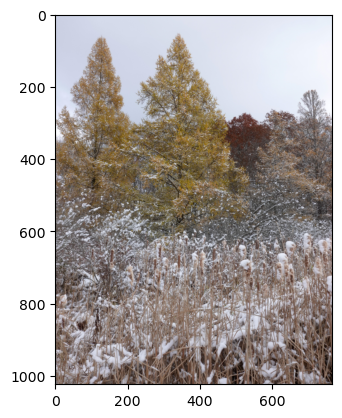

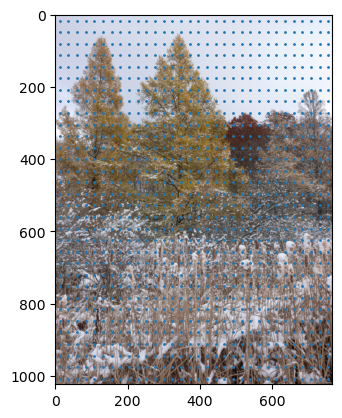

7

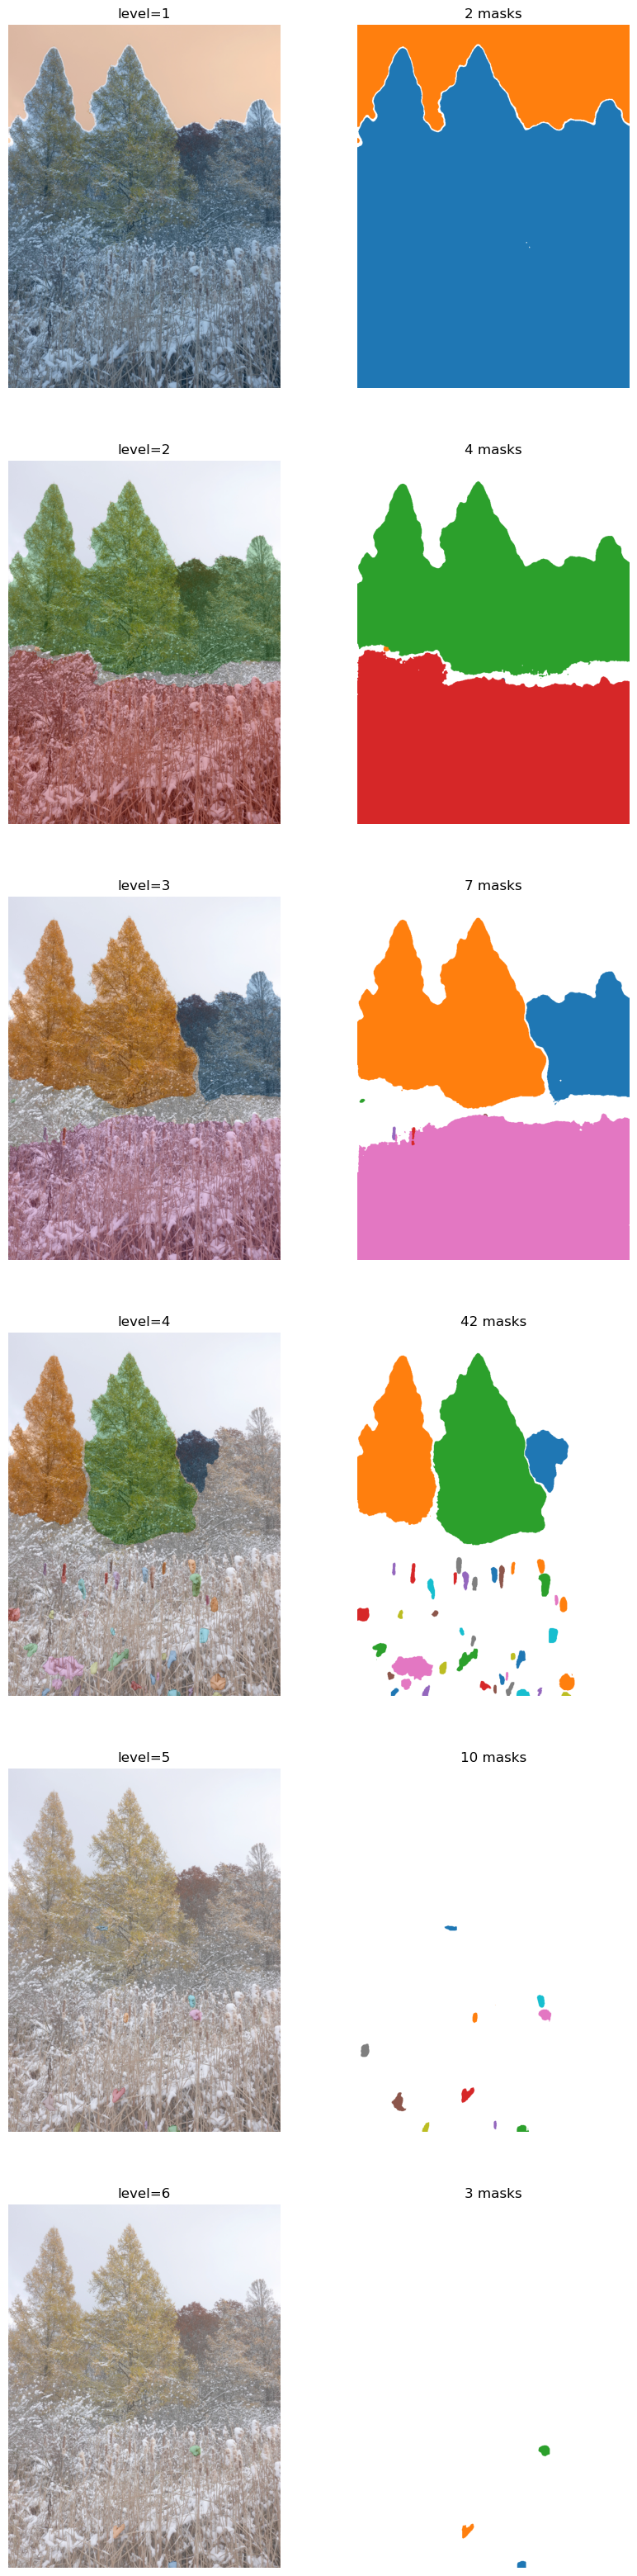

In [15]:
image = utils.load_image('/data5/SA-1B/000110/sa_1240387.jpg')
H, W, _ = image.shape
print((W, H))
scale = min(1024/H, 1024/W)
W, H = int(W*scale), int(H*scale)
print(W, H)
image = cv2.resize(image, (W, H), interpolation=cv2.INTER_AREA)
plt.imshow(image)
plt.show()

tree2d = Tree2D(device=device)
points = tree2d.sample_grid()
plt.imshow(image)
plt.scatter(points[:, 0]*W, points[:, 1]*H, s=1)
plt.show()

tree_seg.set_image(image)
results = tree_seg.process_points(points)
tree2d.insert_batch(results)
tree2d.update_tree()
show_all_levels(image, tree2d)

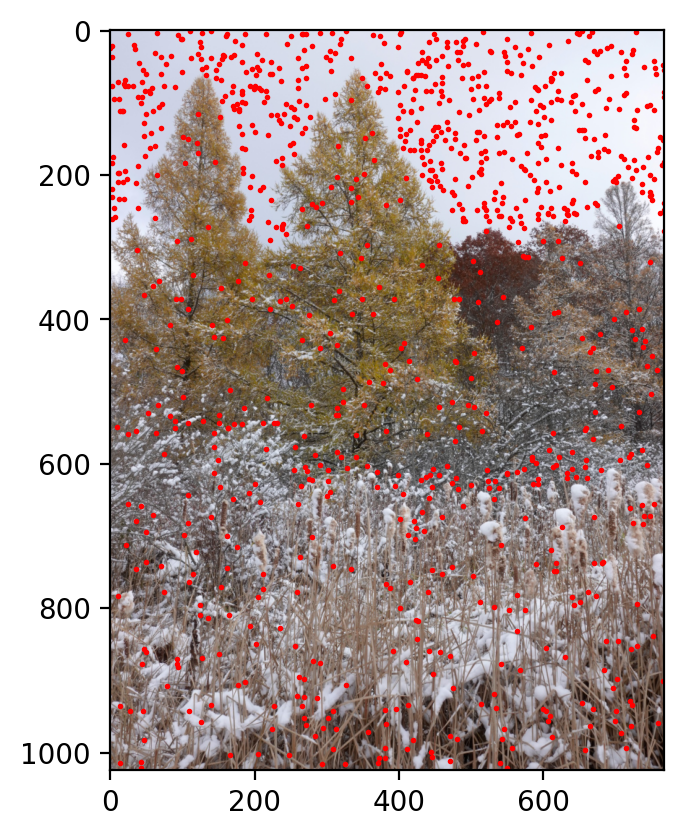

In [23]:
tree2d.num_samples.zero_()
points = tree2d.sample_by_counts(noise=0, rate=0.5)
plt.figure(dpi=200)
plt.imshow(image)
plt.scatter(points[:, 0]*W, points[:, 1]*H, s=1,c='red')
plt.show()

# Evalutate Semantic-SAM-L

In [ ]:
# choose eval images
part_idx = 110 # < 110
num_eval = 10

images_paths =sorted( list(data_root.joinpath(f"{part_idx:06d}").glob('*.jpg')))
np.random.seed(42)
eval_image_paths = np.random.choice(images_paths, num_eval)
print(f"Try To evaluate {len(eval_image_paths)} image")

In [ ]:
# load model
model = semantic_sam_l(Path("./weights/swinl_only_sam_many2many.pth").expanduser())
# model = semantic_sam_t( Path("./weights/swint_only_sam_many2many.pth").expanduser())
model = model.eval().to(device)
tree_seg = TreePredictor(model)
# init metric
metirc = TreeSegmentMetric()

In [ ]:
from tree_segmentation.metric import TreeSegmentMetric
timer = utils.TimeEstimator(num_eval)
time_avg = utils.TimeWatcher()
timer.start()
time_avg.start()
for i, image_path in enumerate(eval_image_paths, 1):
    image = utils.load_image(image_path)
    H, W, _ = image.shape
    scale = min(1024 / H, 1024 / W)
    image = cv2.resize(image, (int(scale * W), int(scale * H)), interpolation=cv2.INTER_AREA)
    time_avg.log('image')
    gt = read_annotations(image_path.with_suffix('.json'))
    time_avg.log('gt')
    prediction = tree_seg.tree_generate(image, device=device)
    time_avg.log('tree2d')
    metirc.update(prediction, gt.to(device), return_match=False)
    time_avg.log('metric')
    timer.step()
    if i % 2 == 0:
        print(f'Process [{i+1}/{num_eval}], time: {timer.progress}',
              ', '.join(f'{k}: {utils.float2str(v)}' for k, v in metirc.summarize().items()))

print('Complete Evalution')
print('Time:', time_avg)
for k, v in metirc.summarize().items():
    print(f"{k:5s}: {v}")